## Setup

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

from parth import *

from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya, loadMCSamples
import getdist.plots as gdplt

from numpy import loadtxt, savetxt, mgrid, argwhere, c_, arange, linspace, reshape
from sympy import symbols, diff, lambdify
from itertools import combinations

from matplotlib.axes import Axes

%matplotlib inline

gdplot = gdplt.get_subplot_plotter()

In [30]:
plt.rcParams.update({"text.usetex": True,"font.family": "serif"})
myColors = ['C1', 'C2', 'C4', 'C3']

In [31]:
tau_value = 0.5

job = f'bbn2_' #t{tau_value}'
i = 0 if tau_value == 0.5 else tau_value
# exact_chain_path = f'/users/stevensonb/Research/DALI/chains/complete/BBN_redux1/37589240/{i}/{i}'
#exact_chain_path=f'/users/stevensonb/scratch/tmp/chains/incomplete/BBN_redux1/37592929/{i}/{i}'
exact_chain_path=f'/users/stevensonb/scratch/tmp/chains/incomplete/t_ext_w5/37794994/{i}/{i}'

# [gparams + removeParams] has to be the complete list of parameters
# [gparams] should be leq size of observables
gparams = ['omega_b_h2', 'N_nu', 'tau']
removeParams = []
fixedParams = {} #'tau': 879.4} #'N_nu': 3} # use {k:v}, values not found in fid will be ignored

experiment = 0
spectrum = 'unlensed'
priorWidth = 1
useDali = True
save_pdf = True
cobaya_debug = False

## Functions

In [32]:
latex_trans = {
    'omega_c_h2':r'\Omega_\mathrm{cdm}h^2', 
    'omega_b_h2':r'\Omega_b h^2', 
    'N_eff':r'N_\mathrm{eff}',
    'N_nu':r'N_\mathrm{eff}', # Just for the effect
    'A_s':r'A_\mathrm{s}', 
    'n_s':r'n_\mathrm{s}', 
    'theta_s':r'\theta_\mathrm{s}',
    'tau':r'\tau_n\;[s]',
    'mnu':r'm_\mathrm{\nu}',
    'eta10':r'\eta_\mathrm{10}'
}

def dp(msg):
    display(msg)

def get_data(file=job + '.pkl', fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params = {}
    with open(file, 'rb') as f:
        data = pickle.load(f)

    fid = data['cosmoFid']
    fisher = data['fisherGaussian'][experiment][spectrum]
    
    # te = np.array([0,0,0.5])
    # print(fisher)
    # fisher += np.linalg.inv(te.T * np.identity(3) * te)
    # print(fisher)
    
    if remove_params:
        for k in remove_params:
            i = list(fid.keys()).index(k)
            fid.pop(k)
            fisher = np.delete(np.delete(fisher, i, 0), i, 1)

    inv = np.linalg.inv(fisher)    
    errors = np.sqrt(np.diag(inv))
    # widths = prior_width * errors
    
    widths = [prior_width * i for i in [1000*0.00022, 0.36, 0.5]]

    for i, (k, v) in enumerate(fid.items()):
        if k not in fixed_params:
            if k == 'tau':
                val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'loc': v, 'scale': prior_width, 'dist': 'norm'}}
            else:
                val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'min': v-widths[i], 'max':v+widths[i]}}
            params.update({k: val})
        else:
            params.update({k: {'value': fixed_params[k], 'latex': latex_trans.get(k, k)}})
            
    return params, fid, inv

def get_model(use_dali=useDali, file=job + '.pkl', fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params, cosmoFid, cov = get_data(file, fixed_params, remove_params, experiment, spectrum, prior_width)

    print(params)
    model = {
        'debug': cobaya_debug,
        'likelihood': {
            'dali': { 
                'python_path': 'likelihoods/dali',
                'use_dali': use_dali,
                'file': file,
                'remove': removeParams,
                'experiment': experiment,
                'spectrum': spectrum
            }
        },
        'params': params,
        'sampler': {
            'mcmc': {
                # 'covmat_params': list(params.keys()),
                # 'covmat': cov,
                'oversample_power': 0.8,
                'proposal_scale': 1.5,
                'Rminus1_stop': 0.05,
                'Rminus1_cl_stop': 0.05,
                'max_tries': 10000,
                # 'max_samples': 1000
            }
        }
    }
    return model

"""
Created on Tuesday, July 26, 2022, at 01:23 PM

@author: Joe Ryan and Cynthia Trendafilova
Modifications by: Brandon Stevenson
"""
def add_KBBN(plotter, 
bounds, 
grid_order = list(combinations(range(0, 3), r=2)), 
plot_order = list(combinations(range(0, 3), r=2)),
contour_levels = [0, 2.3, 6.17], 
data_file = job + '.pkl',
lws=[1, 1, 1],
colors=myColors,
exp=experiment, 
spec=spectrum,
grid_size=16j,
linspace_size=50,
alphas=[0.5,0.5,1]
):
    """
    Note: girid_order and plot_order must be the same length
    """

    with open(data_file, 'rb') as f:
        data_BBN = pickle.load(f)
    
    fid = data_BBN['cosmoFid']
    F = data_BBN['fisherGaussian'][exp][spec]
    G = data_BBN['DALI3Gaussian'][exp][spec]
    H = data_BBN['DALI4Gaussian'][exp][spec]
    
    x = symbols('x', real=True)
    y = symbols('y', real=True)

    p_names = list(fid.keys())
    p_fid = list(fid.values())

    for q in range(0, len(plot_order), 1):        
        i = plot_order[q][0]
        j = plot_order[q][1]
        ij = [i, j]
        
        p = [x - p_fid[i], y - p_fid[j]]
        
        sumF = (-1/2)*(F[i][i]*p[0]*p[0] + F[i][j]*p[0]*p[1] + F[j][i]*p[1]*p[0] + F[j][j]*p[1]*p[1])
        sumG = 0
        sumH = 0
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    sumG += (-1/2)*G[ij[a]][ij[b]][ij[c]]*p[a]*p[b]*p[c]
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    for d in range(0, 2, 1):
                        sumH += (-1/8)*H[ij[a]][ij[b]][ij[c]][ij[d]]*p[a]*p[b]*p[c]*p[d]
                        
        Phi = -(sumF + sumG + sumH)
        
        Phi0 = diff(Phi, x)
        Phi1 = diff(Phi, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_D = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeD = argwhere(K_D <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeD)
    
        ### Sanity check:
        Phi_F = -sumF
        
        Phi0 = diff(Phi_F, x)
        Phi1 = diff(Phi_F, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_F = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeF = argwhere(K_F <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_Fisher_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeF)
        
        #if len(negativeD) != 0:
        X0 = []
        X1 = []
        
        for u in arange(0, len(negativeD), 1):
            I0 = negativeD[u][0]
            I1 = negativeD[u][1]
            
            X0.append(x0[I0][I1])
            X1.append(x1[I0][I1])
            
        ### Save coordinates:
        # savetxt('coords_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', c_[X0, X1])
    
        ### Plot coordinates at which K <= 0 over Fisher and Doublet cross-section contours:
       
        X = linspace(bounds[i][0], bounds[i][1], linspace_size)
        Y = linspace(bounds[j][0], bounds[j][1], linspace_size)
        
        Z = []
        Z_F = []
        xl = []
        yl = []
        
        Phi_L = lambdify([x, y], Phi)
        Phi_FL = lambdify([x, y], Phi_F)
        for xc0 in X:
            for xc1 in Y:
                Z.append(Phi_L(xc0, xc1))
                Z_F.append(Phi_FL(xc0, xc1))
                xl.append(xc0)
                yl.append(xc1)    

        x_2d = reshape(xl, (linspace_size, linspace_size))
        y_2d = reshape(yl, (linspace_size, linspace_size))
        z_2d = reshape(Z, (linspace_size, linspace_size))
        zf_2d = reshape(Z_F, (linspace_size, linspace_size))

        ax = plotter.get_axes(grid_order[q])

        # set labels in accordance with plotter style
        lab_fontsize = plotter._scaled_fontsize(plotter.settings.axes_labelsize)
        ax.set_xlabel('$'+latex_trans.get(p_names[i], p_names[i])+'$',  fontsize=lab_fontsize, verticalalignment='baseline', labelpad=4 + lab_fontsize)
        ax.set_ylabel('$'+latex_trans.get(p_names[j] , p_names[j])+'$', fontsize=lab_fontsize)

        tick_label_size = plotter._scaled_fontsize(None, plotter.settings.axes_fontsize)
        ax.tick_params(which='major', labelsize=tick_label_size)
        # ax.get_offset_text().set_fontsize(tick_label_size * 3 / 4 if tick_label_size > 7 else tick_label_size)

        ax.set_xlim(bounds[i][0], bounds[i][1])
        ax.set_ylim(bounds[j][0], bounds[j][1])
        
        ax.contour(x_2d, y_2d, zf_2d, contour_levels, colors=colors[2], linestyles='dotted', zorder=1, linewidths=lws, alpha=alphas[0]).collections[0].set_label('Fisher') # fisher
        ax.contour(x_2d, y_2d, z_2d, contour_levels, colors=colors[1], linestyles='dashed', zorder=2, linewidths=lws, alpha=alphas[1]).collections[0].set_label('Doublet') 
        ax.scatter(X0, X1, marker='.', color=colors[3], zorder=3, label='Concavity', alpha=alphas[2])

## Analysis

In [33]:
# gdsExact = loadMCSamples(exact_chain_path)
# gdsExact.name_tag = 'Exact'

# TODO change to NDGauss.... instead of sampling
# updatedFisher, samplerFisher = run(get_model(use_dali=False));
# gdsFisher = MCSamplesFromCobaya(updatedFisher, samplerFisher.products()["sample"], name_tag='Fisher');

updatedDali, samplerDali = run(get_model(use_dali=True));
gdsDali = MCSamplesFromCobaya(updatedDali, samplerDali.products()["sample"], name_tag='Doublet');

{'omega_b_h2': {'ref': 0.02242, 'latex': '\\Omega_b h^2', 'prior': {'min': -0.19758, 'max': 0.24242}}, 'N_nu': {'ref': 3.0, 'latex': 'N_\\mathrm{eff}', 'prior': {'min': 2.64, 'max': 3.36}}, 'tau': {'ref': 879.4, 'latex': '\\tau_n\\;[s]', 'prior': {'loc': 879.4, 'scale': 1, 'dist': 'norm'}}}
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 3820.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_b_h2:0.02242, N_nu:3, tau:879.4
[mcmc] Sampling!
[mcmc] Progress @ 2022-10-18 21:16:26 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.405
[mcmc]  - Convergence of means: R

[[ 500.266865   -250.22172179   -0.84662462]
 [-250.22172179  155.09801798    0.86275049]
 [  -0.84662462    0.86275049    4.00787751]]
[[0.10179388 0.12932516        nan]
 [0.12932516 0.18289505        nan]
 [       nan        nan 0.5       ]]


<ipython-input-34-8f356f3ecad4>:13: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(inv))


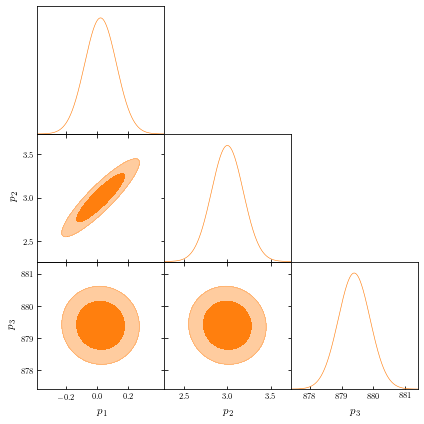

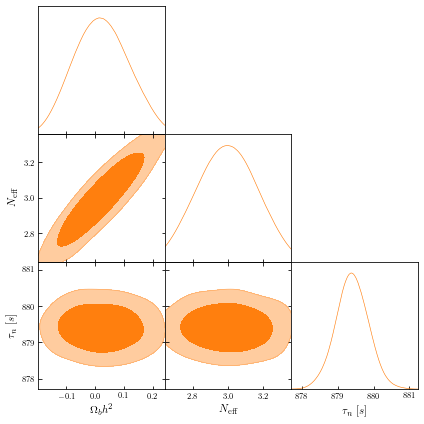

In [34]:
params = [i for i in gparams if i not in fixedParams.keys()]
# gdplot.triangle_plot(gdsExact, params, filled=True, colors=myColors, contour_colors=myColors)
# gdplot.triangle_plot(gdsFisher, params, filled=True, colors=myColors, contour_colors=myColors)

with open(job + '.pkl', 'rb') as f:
    data = pickle.load(f)

from getdist import gaussian_mixtures
fid = data['cosmoFid']
fisher = np.asmatrix(data['fisherGaussian'][experiment][spectrum])
inv = np.linalg.inv(fisher)
print(fisher)
print(np.sqrt(inv))
fa = gaussian_mixtures.GaussianND(list(fid.values()), inv)
gdplot.triangle_plot(fa, filled=True, colors=myColors, contour_colors=myColors)

gdplot.triangle_plot(gdsDali, params, filled=True, colors=myColors, contour_colors=myColors)

## Finalize

In [35]:
contour_line_widths = [1,1,1]
contour_widths = [0.6,0.6,0.6]

# self.solid_colors = ['#006FED', '#E03424', 'gray', '#009966', '#000866', '#336600', '#006633', 'm', 'r']
# self.alpha_filled_add = 0.85
# self.alpha_factor_contour_lines = 0.5

gdplot.triangle_plot([gdsExact, gdsDali, gdsFisher], gparams, filled=[True, True, False], colors=myColors, contour_colors=myColors, contour_lws=contour_line_widths, legend_ncol=3)

xbounds = [gdplot.get_axes((0,0)).get_xlim(), gdplot.get_axes((1,1)).get_xlim(), gdplot.get_axes((2,2)).get_xlim()]
add_KBBN(gdplot, bounds=xbounds, plot_order=[[1,0], [2,0], [2,1]], contour_levels = [0, 2.3, 6.17], lws=contour_widths, alphas=[1, 0.5, 1])

#Clean up time
a: Axes = gdplot.get_axes((0,1))
b: Axes = gdplot.get_axes((0,2))
c: Axes = gdplot.get_axes((1,2))

# add bars to seperate the curvature from posteriors
bar_thickness = 3.0
a.spines['left'].set_linewidth(bar_thickness)
a.spines['bottom'].set_linewidth(bar_thickness)
c.spines['left'].set_linewidth(bar_thickness)
c.spines['bottom'].set_linewidth(bar_thickness)

#fix ticks and labels
a.tick_params(axis='both', direction = 'in', labeltop = True, labelbottom = False, labelleft = False, labelright = False, top=True, bottom=True, left=False, right=True)
b.tick_params(axis='both', direction = 'in', labeltop = True, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=True, right=True)
c.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=False, right=True)

a.get_xaxis().set_label_position('top')
a.get_yaxis().set_label_position('right')
b.get_xaxis().set_label_position("top")
b.get_yaxis().set_label_position("right")
c.get_yaxis().set_label_position("right")
c.set_xlabel('')

#fix the tick labels
a.set_xticks(gdplot.get_axes((1,1)).get_xticks())
b.set_xticks(gdplot.get_axes((2,2)).get_xticks())
c.set_xticks(gdplot.get_axes((2,2)).get_xticks())

a.set_yticks(gdplot.get_axes((0,0)).get_xticks())
b.set_yticks(gdplot.get_axes((0,0)).get_xticks())
c.set_yticks(gdplot.get_axes((1,1)).get_xticks())

# legends
gdplot.legend.set_bbox_to_anchor((0.75, 0.015), transform=gdplot.fig.transFigure)
gdplot.legend.set_title('Marginalized posteriors')

# Top left
# legend_2 = c.legend(ncol=2, bbox_to_anchor=(0.4, 1.1), bbox_transform=gdplot.fig.transFigure)
# Top Center
legend_2 = c.legend(ncol=3, bbox_to_anchor=(0.8, 1.15), bbox_transform=gdplot.fig.transFigure)
#bottom center
#legend_2 = c.legend(ncol=3, bbox_to_anchor=(0, -0.15), bbox_transform=gdplot.fig.transFigure)
legend_2.set_title('Likelihood contours')

# fix overlapping of curvature points on some borders
for ax in [a,b,c]:
    for k, spine in ax.spines.items():
        spine.set_zorder(10)

if save_pdf:
    # export wasn't adjusting overall figure size to fit the curvature legend, so we do it manually
    # gdplot.export(job + '.pdf')
    gdplot.fig.savefig(job + '.pdf', bbox_extra_artists=gdplot.extra_artists + [legend_2], bbox_inches='tight')

NameError: name 'gdsExact' is not defined